## https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again

In [235]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit, GroupKFold
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()

%matplotlib inline

In [77]:
%%time
folder_path = '../Inputs/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

Wall time: 35.2 s


In [78]:
########################### All features columns
#################################################################################
## Main Data
# 'TransactionID',                     -> This is pure noise, we cannot use this column as feature
# 'isFraud',                           -> Our Target
# 'TransactionDT',                     -> Time from reference time point. VERY valuable column
# 'TransactionAmt',                    -> Many unique values and has to be combined with other columns
#                                         The best score boost should come from 
#                                         TransactionDT->TransactionAmt combination
# 'ProductCD',                         -> 100% categorical feature options to use:
#                                         Frequency encoding/Target encoding/
#                                         Combinations with other columns/Model categorical feature
# 'card1' - 'card6',                   -> Categorical features with information about Client
# 'addr1' - 'addr2',                   -> add2 - Country / addr1 - subzone
# 'dist1' - 'dist2',                   -> dist2 - Country distance / dist1 - local distance from merchant
# 'P_emaildomain' - 'R_emaildomain',   -> Categorical feature. It's possible to make 
#                                         subgroup feature from it or general group
# 'C1' - 'C14'                         -> Counts. Should be numerical features (all ints?)
# 'D1' - 'D15'                         
# 'M1' - 'M9'
# 'V1' - 'V339'

## Identity Data
# 'TransactionID'
# 'id_01' - 'id_38'
# 'DeviceType',
# 'DeviceInfo'
########################### D9 and TransactionDT

In [146]:
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [147]:
# del test_identity, test_transaction, train_identity, train_transaction
gc.collect()

2184

In [148]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [149]:
########################### D9 and TransactionDT
# Let's add temporary "time variables" for aggregations
# and add normal "time variables"

# Also, seems that D9 column is an hour
# and it is the same as df['DT'].dt.hour
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

for df in [train, test]:
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # D9 column
    df['D9'] = np.where(df['D9'].isna(),0,1)

In [150]:
########################### Reset values for "noise" card1
i_cols = ['card1']

for col in i_cols: 
    valid_card = pd.concat([train[[col]], test[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card = valid_card[valid_card>2]
    valid_card = list(valid_card.index)

    train[col] = np.where(train[col].isin(test[col]), train[col], np.nan)
    test[col]  = np.where(test[col].isin(train[col]), test[col], np.nan)

    train[col] = np.where(train[col].isin(valid_card), train[col], np.nan)
    test[col]  = np.where(test[col].isin(valid_card), test[col], np.nan)

In [151]:
########################### M columns (except M4)
# All these columns are binary encoded 1/0
# We can have some features from it
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [train, test]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)

In [152]:
########################### ProductCD and M4 Target mean
for col in ['ProductCD','M4']:
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train[col+'_target_mean'] = train[col].map(temp_dict)
    test[col+'_target_mean']  = test[col].map(temp_dict)

In [153]:
########################### TransactionAmt

# Let's add some kind of client uID based on cardID ad addr columns
# The value will be very specific for each client so we need to remove it
# from final feature. But we can use it for aggregations.
train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card5'].astype(str)

train['uid3'] = train['uid2'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid3'] = test['uid2'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

# Check if the Transaction Amount is common or not (we can use freq encoding here)
# In our dialog with a model we are telling to trust or not to these values   
train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check']  = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

# For our model current TransactionAmt is a noise
# https://www.kaggle.com/kyakovlev/ieee-check-noise
# (even if features importances are telling contrariwise)
# There are many unique values and model doesn't generalize well
# Lets do some aggregations
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)
           
# Small "hack" to transform distribution 
# (doesn't affect auc much, but I like it more)
# please see how distribution transformation can boost your score 
# (not our case but related)
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])        

In [154]:
########################### 'P_emaildomain' - 'R_emaildomain'
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

for df in [train, test]:
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])

## Local test doesn't show any boost here, 
## but I think it's a good option for model stability 

## Also, we will do frequency encoding later

In [155]:
########################### Device info
for df in [train, test]:
    ########################### Device info
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Device info 2
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [156]:
########################### Freq encoding
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31_device',
          'id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)
        

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train[[col,period]], test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period+'_total']
        test[new_column]  /= test[period+'_total']

In [157]:
train.select_dtypes('O').head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,uid,uid2,uid3,P_emaildomain_prefix,R_emaildomain_prefix,DeviceInfo_device,DeviceInfo_version,id_30_device,id_30_version,id_31_device
0,W,discover,credit,email_not_provided,email_not_provided,T,T,T,M2,F,...,13926.0_nan,13926.0_nan_150.0_142.0,13926.0_nan_150.0_142.0_315.0_87.0,email_not_provided,email_not_provided,unknowndevice,,unknowndevice,,unknowndevice
1,W,mastercard,credit,gmail.com,email_not_provided,NaN,NaN,NaN,M0,T,...,2755.0_404.0,2755.0_404.0_150.0_102.0,2755.0_404.0_150.0_102.0_325.0_87.0,gmail,email_not_provided,unknowndevice,,unknowndevice,,unknowndevice
2,W,visa,debit,outlook.com,email_not_provided,T,T,T,M0,F,...,4663.0_490.0,4663.0_490.0_150.0_166.0,4663.0_490.0_150.0_166.0_330.0_87.0,outlook,email_not_provided,unknowndevice,,unknowndevice,,unknowndevice
3,W,mastercard,debit,yahoo.com,email_not_provided,NaN,NaN,NaN,M0,T,...,18132.0_567.0,18132.0_567.0_150.0_117.0,18132.0_567.0_150.0_117.0_476.0_87.0,yahoo,email_not_provided,unknowndevice,,unknowndevice,,unknowndevice
4,H,mastercard,credit,gmail.com,email_not_provided,NaN,NaN,NaN,NaN,NaN,...,4497.0_514.0,4497.0_514.0_150.0_102.0,4497.0_514.0_150.0_102.0_420.0_87.0,gmail,email_not_provided,samsungsmgabuildnrdm,89290,android,70,samsungbrowser


In [158]:
########################### Encode Str columns
# For all such columns (probably not)
# we already did frequency encoding (numeric feature)
# so we will use astype('category') here
for col in tqdm_notebook(train.columns):
    if train[col].dtype=='O':
        print(col)
        train[col] = train[col].fillna('unseen_before_label')
        test[col]  = test[col].fillna('unseen_before_label')
        
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train[col])+list(test[col]))
        train[col] = le.transform(train[col])
        test[col]  = le.transform(test[col])
        
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo
uid
uid2
uid3
P_emaildomain_prefix
R_emaildomain_prefix
DeviceInfo_device
DeviceInfo_version
id_30_device
id_30_version
id_31_device



In [159]:
########################### Model Features 
## We can use set().difference() but the order matters
## Matters only for deterministic results
## In case of remove() we will not change order
## even if variable will be renamed
## please see this link to see how set is ordered
## https://stackoverflow.com/questions/12165200/order-of-unordered-python-sets
rm_cols = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
     'isFraud',                          # Not target in features))
    'uid','uid2','uid3',             # Our new client uID -> very noisy data
    'bank_type',                     # Victims bank could differ by time
    'DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
]

In [160]:
########################### Features elimination 
from scipy.stats import ks_2samp
features_check = []
base_columns = list(train) + list(train_identity)
columns_to_check = set(list(train)).difference(base_columns + rm_cols)

for i in columns_to_check:
    features_check.append(ks_2samp(test[i], train[i])[1])

features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)
print(features_discard)

# We will reset this list for now (use local test drop),
# Good droping will be in other kernels
# with better checking
features_discard = [] 

# Final features list
features_columns = [col for col in list(train) if col not in rm_cols + features_discard]

[]


In [161]:
len(features_columns)

501

In [144]:
X = train[features_columns]
y = train['isFraud']

In [163]:
test = test[features_columns]

In [164]:
# del train
gc.collect()

880

In [165]:
X.shape, test.shape

((590540, 501), (506691, 501))

In [166]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
folds = TimeSeriesSplit(n_splits=5)

In [223]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    if fold < 4:
        continue
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=100)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[862]	training's auc: 0.999325	valid_1's auc: 0.936248
Fold 5 finished in 0:09:56.178874
------------------------------
Training has finished.
Total training time is 0:09:56.187526
Mean AUC: 0.9362477006974544
------------------------------


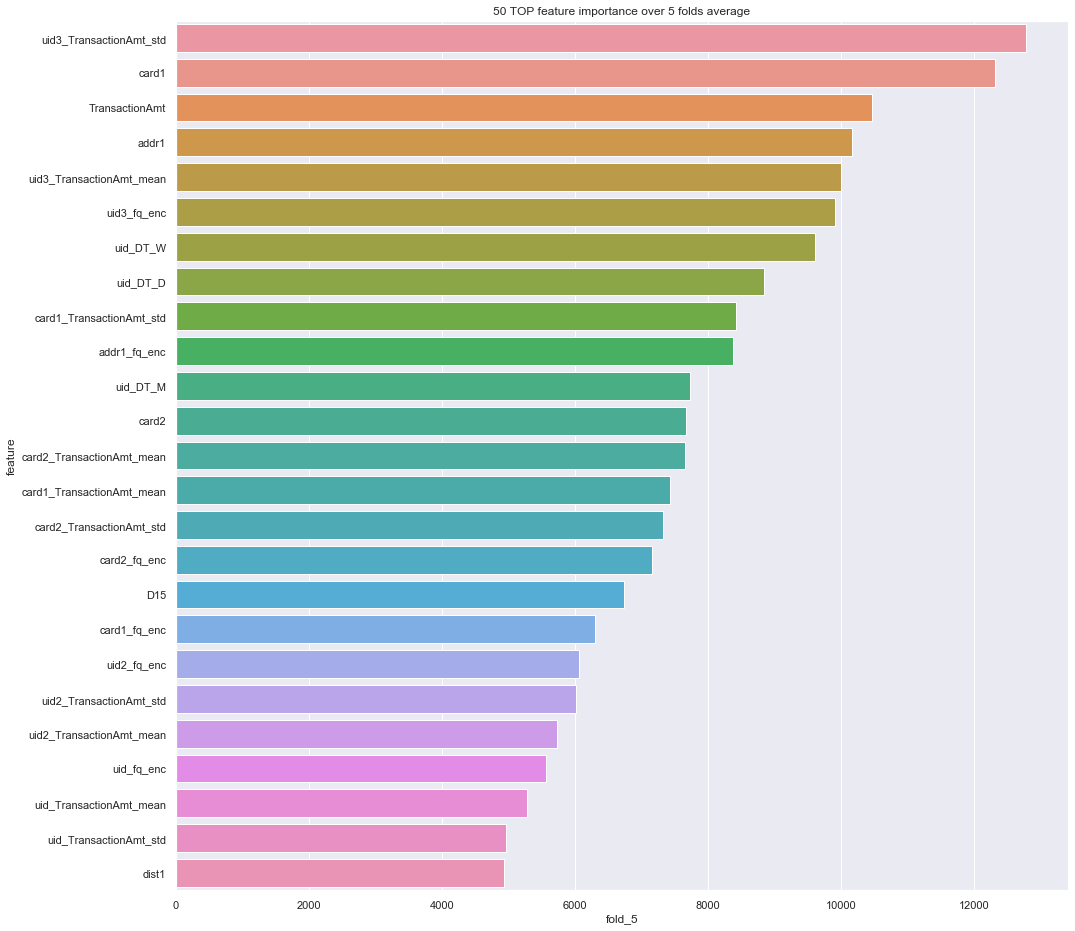

In [224]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='fold_5', ascending=False).head(25), x='fold_5', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [200]:
# (feature_importances.sort_values(by='fold_5', ascending=False)).reset_index(drop=True).rename(columns={'fold_5':'feature_imp'}).to_csv('Feature_imporance.csv', index=False)

In [169]:
# clf right now is the last model, trained with 80% of data and validated with 20%
best_iter = clf.best_iteration

In [176]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.3797454081646243, importance_type='split',
               learning_rate=0.01, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.03454472573214212,
               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=862, num_leaves=491,
               objective='binary', random_state=47,
               reg_alpha=0.3899927210061127, reg_lambda=0.6485237330340494,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, verbosity=-1)

In [177]:
sub['isFraud'] = clf.predict_proba(test)[:, 1]
sub.to_csv('ieee_cis_fraud_detection_v4.csv', index=False)

### Bagging using KFOLD

In [225]:
# clf right now is the last model, trained with 80% of data and validated with 20%
best_iter = clf.best_iteration

In [233]:
np.unique(train['DT_M'])

array([12, 13, 14, 15, 16, 17], dtype=int64)

In [238]:
NFOLDS = 5
folds_ = GroupKFold(n_splits=NFOLDS)
split_groups = train['DT_M']
predictions = np.zeros(test.shape[0])

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds_.split(X, y, groups=split_groups)):

    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
    clf.fit(X.iloc[trn_idx], y[trn_idx])    
    predictions =+ clf.predict_proba(test)[:, 1]/NFOLDS
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training/Prediction has finished.')
print('Total time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('-' * 30)

Training on fold 1
Fold 1 finished in 0:08:07.899873
Training on fold 2
Fold 2 finished in 0:08:29.857241
Training on fold 3
Fold 3 finished in 0:08:48.602452
Training on fold 4
Fold 4 finished in 0:08:32.163369
Training on fold 5
Fold 5 finished in 0:07:30.134362
------------------------------
Training/Prediction has finished.
Total time is 0:41:28.729074
------------------------------


In [239]:
sub['isFraud'] = predictions
sub.to_csv('ieee_cis_fraud_detection_v6.csv', index=False)

### Training on top features

In [215]:
top_features = feature_importances.sort_values(by='fold_5', ascending=False).head(400)['feature']

In [216]:
X_top_featuers = train[top_features]
test_top_features = test[top_features]

In [217]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_top_featuers.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_top_featuers, y)):
    if fold < 4:
        continue
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_top_featuers.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X_top_featuers.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=100)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 5
Training until validation scores don't improve for 100 rounds.


KeyboardInterrupt: 

In [ ]:
best_iter = clf.best_iteration
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

In [ ]:
sub['isFraud'] = clf.predict_proba(test_top_features_features)[:, 1]
sub.to_csv('ieee_cis_fraud_detection_v4.csv', index=False)